In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
path = Path('../input/imdb-movie-review')

In [2]:
import os
os.listdir(path)

['Valid.csv', 'Train.csv', 'Test.csv']

In [3]:
train = pd.read_csv(path / 'Train.csv')
test = pd.read_csv(path / 'Test.csv')
valid= pd.read_csv(path / 'Valid.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
train['text'].loc[11]

"If you haven't seen the gong show TV series then you won't like this movie much at all, not that knowing the series makes this a great movie. <br /><br />I give it a 5 out of 10 because a few things make it kind of amusing that help make up for its obvious problems.<br /><br />1) It's a funny snapshot of the era it was made in, the late 1970's and early 1980's. 2) You get a lot of funny cameos of people you've seen on the show. 3) It's interesting to see Chuck (the host) when he isn't doing his on air TV personality. 4) You get to see a lot of bizarre people doing all sorts of weirdness just like you see on the TV show.<br /><br />I won't list all the bad things because there's a lot of them, but here's a few of the most prominent.<br /><br />1) The Gong Show Movie has a lot of the actual TV show clips which gets tired at movie length. 2) The movie's story line outside of the clip segments is very weak and basically is made up of just one plot point. 3) Chuck is actually halfway decen

In [7]:
train.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
train.memory_usage(deep = True)

Index         128
text     54863989
label      320000
dtype: int64

In [9]:
train.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

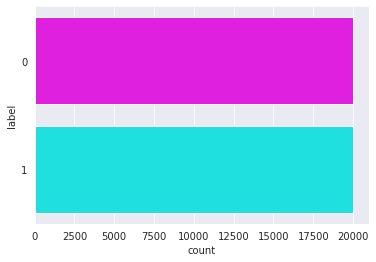

In [10]:
import seaborn as sns
sns.set_style('darkgrid')
ax = sns.countplot(y = train.label,palette = {0 : 'magenta', 1 : 'cyan'})

In [11]:
import matplotlib.pyplot as plt

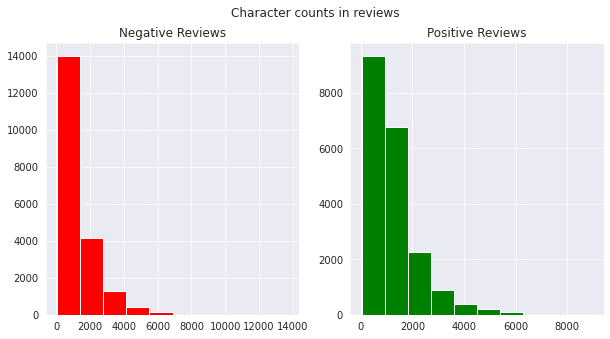

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
review_len=train[train['label']==1]['text'].str.len()
ax1.hist(review_len,color='red')
ax1.set_title('Negative Reviews')
review_len=train[train['label']==0]['text'].str.len()
ax2.hist(review_len,color='green')
ax2.set_title('Positive Reviews')
fig.suptitle('Character counts in reviews')
plt.show()

In [13]:
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
positive = train[train['label'] == 1]
negative = train[train['label'] == 0]

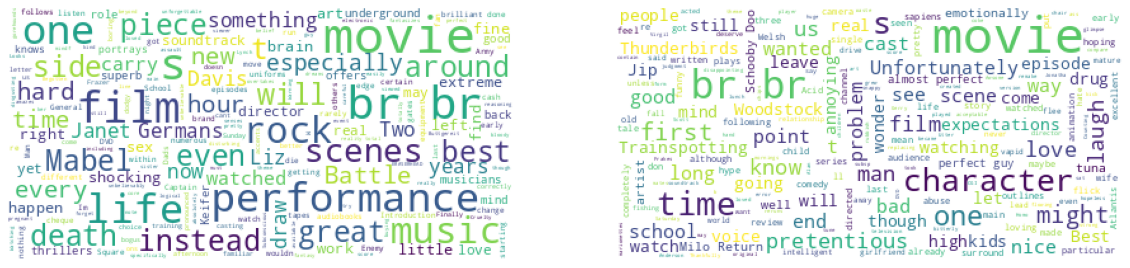

In [14]:
from wordcloud import WordCloud
text = str(positive['text'].values)
wordcloud_positive = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(text)
text = str(negative['text'].values)
wordcloud_negative = WordCloud(
                          background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(text)
plt.figure(figsize = (20,20))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative)
plt.axis('off')
plt.show()

In [15]:
del positive; del negative; del wordcloud_positive; del wordcloud_negative

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

2021-10-02 23:48:26.944994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
bert_model_name = 'bert-base-cased'
roberta_model_name = 'roberta-base'

In [19]:
#bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
sample_text = train['text'].loc[0]
print(sample_text)

I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.


In [21]:
tokens = roberta_tokenizer.tokenize(sample_text)
ids = roberta_tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {ids}')

 Sentence: I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.
   Tokens: ['I', 'Ġgrew', 'Ġup', 'Ġ(', 'b', '.', 'Ġ1965', ')', 'Ġwatching', 'Ġand', 'Ġloving', 'Ġthe', 'ĠThunder',

In [22]:
encodings = roberta_tokenizer.encode_plus(
    sample_text,
    max_length = 160,
    padding = 'max_length',
    truncation = True,
    return_attention_mask = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [23]:
print(len(encodings['input_ids'][0]))
print(encodings['input_ids'][0])

160
tensor([    0,   100,  2307,    62,    36,   428,     4, 18202,    43,  2494,
            8,  8520,     5,  8314, 17921,     4,   404,   127, 18779,    23,
          334,  3996,     4,   166,   702,    22, 43032, 17921,   113,   137,
          334,     6,   148,  4592,     8,    71,   334,     4,   166,    70,
          770,     7,    28,  9541, 24175,    50,  1699,     4,   440,    65,
          770,     7,    28,  6284,     4, 12440,   154,   159,    31,   195,
         1059,    41,  1808,  1026,     4,    38,   362,   127,   408,     7,
          192,     5,  1569,  2818,    51,    74,   120,    10, 11986,     9,
           99,    38,  2638,    25,    10,   920,     4,  1336, 31337,  6770,
            4,    20,   129,   239,   477,    21,     5,  4543, 31953,  4782,
         8859,     4,  1491,    14,    24,   115,  8933,    19,     5,  1461,
         1471,     9,     5,  8314, 17921,     4, 19883,   419,   378, 19905,
           65,  2384,  4238,   202,  1974,   769, 39478,    

In [24]:
print(len(encodings['attention_mask'][0]))
encodings['attention_mask']

160


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [25]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, maxlen):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.label
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        text = self.text.to_numpy()
        targets = self.targets.to_numpy()
        inputs = self.tokenizer.encode_plus(
            text[idx],
            max_length = self.maxlen,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
            )
        
        ids = inputs['input_ids'].flatten()
        mask = inputs['attention_mask'].flatten()
        
        return {
            'ids'  : ids,
            'mask' : mask,
            'targets' : torch.tensor(targets[idx], dtype = torch.long)
        }

In [26]:
max_len = 180
train_batch_size = 16
validation_batch_size = 16

In [27]:
train_dataset = TextDataset(train, roberta_tokenizer, max_len)
test_dataset = TextDataset(valid, roberta_tokenizer, max_len)

In [28]:
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, num_workers = 2, shuffle = True)
val_loader = DataLoader(test_dataset, batch_size = validation_batch_size, num_workers = 2, shuffle = True)

In [29]:
data = next(iter(train_loader))
data.keys()

dict_keys(['ids', 'mask', 'targets'])

In [30]:
print(data['ids'].shape)
print(data['mask'].shape)
print(data['targets'].shape)

torch.Size([16, 180])
torch.Size([16, 180])
torch.Size([16])


In [43]:
class CustomModel(nn.Module):
    def __init__(self, model,model_name, n_classes = 2):
        super(CustomModel, self).__init__()
        self.encoder = model.from_pretrained(model_name)
        self.drop = nn.Dropout(p = 0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size,n_classes)
        #self.classifier2 = nn.Linear(768, n_classes)
    def forward(self, input_ids, attention_mask):
        hidden_state, pooled_output = self.encoder(input_ids, attention_mask, return_dict = False)
        output = self.drop(pooled_output)
        output = self.classifier(output)
        return output

In [38]:
from transformers import RobertaModel

In [44]:
model = CustomModel(RobertaModel, roberta_model_name).to(device)

In [45]:
num_epochs = 2
total_steps = len(train_loader) * num_epochs
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [46]:
input_ids = data['ids'].to(device)
attention_mask = data['mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.shape) 
print(attention_mask.shape)
print(input_ids.dtype, attention_mask.dtype, targets.dtype)

torch.Size([16, 180])
torch.Size([16, 180])
torch.int64 torch.int64 torch.int64


In [47]:
torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.6438, 0.3562],
        [0.5616, 0.4384],
        [0.5779, 0.4221],
        [0.6034, 0.3966],
        [0.5383, 0.4617],
        [0.5878, 0.4122],
        [0.5621, 0.4379],
        [0.5528, 0.4472],
        [0.5238, 0.4762],
        [0.5674, 0.4326],
        [0.6283, 0.3717],
        [0.6010, 0.3990],
        [0.6165, 0.3835],
        [0.5089, 0.4911],
        [0.5625, 0.4375],
        [0.5964, 0.4036]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [58]:
def train_loop(model, data_loader, loss_function, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['ids'].to(device)
        attention_mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        logits = model(input_ids, attention_mask)
        _, preds = torch.max(logits, dim = 1)
        loss = loss_function(logits, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [59]:
def evaluate(model, data_loader, loss_function, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['ids'].to(device)
            attention_mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim = 1)
            loss = loss_function(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)   

In [60]:
from collections import defaultdict
from tqdm.notebook import tqdm

In [61]:
%%time

summary = defaultdict(list)
accuracy_best = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} / {num_epochs}')
    train_acc, train_loss = train_loop(model, train_loader, loss_function, optimizer, device, scheduler, len(train))
    print(f'Train Loss {train_loss} || Train accuracy {train_acc}')
    val_acc, val_loss = evaluate(model, val_loader, loss_function, device, len(valid))
    print(f'Validation Loss {val_loss} || Validation accuracy {val_acc}')
    print()
    summary['train_acc'].append(train_acc)
    summary['train_loss'].append(train_loss)
    summary['val_acc'].append(val_acc)
    summary['val_loss'].append(val_loss)
    
    if val_acc > accuracy_best:
        torch.save(model.state_dict(), 'best_model_state.bin')
        accuracy_best = val_acc

Epoch 1 / 2


  0%|          | 0/2500 [00:00<?, ?it/s]

Train Loss 0.2810322218699381 || Train accuracy 0.8921


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss 0.22363531019110172 || Validation accuracy 0.914

Epoch 2 / 2


  0%|          | 0/2500 [00:00<?, ?it/s]

Train Loss 0.17908582273973153 || Train accuracy 0.94415


  0%|          | 0/313 [00:00<?, ?it/s]

Validation Loss 0.2817858890295564 || Validation accuracy 0.9166000000000001

CPU times: user 27min 36s, sys: 7.85 s, total: 27min 44s
Wall time: 28min 23s


(0.0, 1.0)

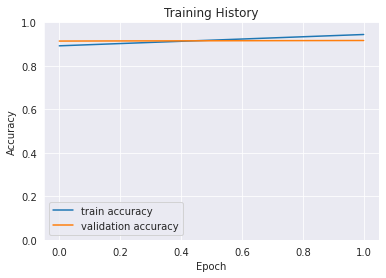

In [62]:
plt.plot(summary['train_acc'], label = 'train accuracy')
plt.plot(summary['val_acc'], label = 'validation accuracy')

plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1])

In [70]:
def test_predictions(model, test_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)
            
            logits = model(ids, mask)
            _, preds = torch.max(logits, dim = 1)
            probs = F.softmax(logits, dim = 1)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

In [71]:
test = pd.read_csv(path / 'Test.csv')

In [72]:
test_dataset = TextDataset(test, roberta_tokenizer, max_len)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [73]:
y_pred, y_pred_probs, y_test = test_predictions(
  model,
  test_dataloader
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [74]:
print(classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.93      0.92      0.92      2495
    Negative       0.92      0.93      0.93      2505

    accuracy                           0.93      5000
   macro avg       0.93      0.92      0.92      5000
weighted avg       0.93      0.93      0.92      5000



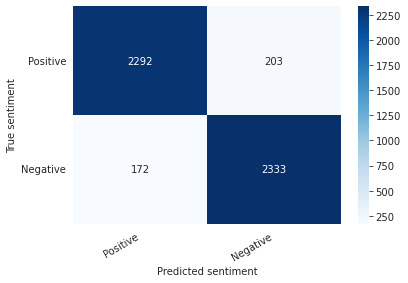

In [75]:
def plot_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['Positive', 'Negative'], columns=['Positive', 'Negative'])
plot_confusion_matrix(df_cm)